<a href="https://colab.research.google.com/github/CMallart/ateliers-NN/blob/main/Creation_de_paysages_par_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data from :
https://www.kaggle.com/arnaud58/landscape-pictures?select=00000001_%285%29.jpg

# Generative adversarial networks

Les réseaux de neurones peu profonds sont somme toute des versions un peu compliquées de classifieurs statistiques, utilisés le plus souvent pour classifier des objets (phrases, images, audio, videos...) en plusieurs catégories.Il faut leur créer des variables(features) à la main et éspérer que cela leur parle.

Mais les réseaux de neurones profonds, eux, permettent de faire quelque chose de beaucoup plus puissante : ils apprennent des représentations. Ils peuvent apprendre directement, sans création de features à la main, des représentations par matrices d'objets complexes, comme des images. Cela serait dommage de ne pas exploiter cela pour quelque chose de plus puissant, ou au moins de différent.

Entrent en jeu les réseaux génératifs. Ces réseaux profitent du fait qu'on peut apprendre à un réseau à créer une représentation abstraite, vectorielle, d'un objet. 


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

Found 4335 images belonging to 1 classes.
(256, 256, 3) [[[124. 149. 127.]
  [125. 150. 128.]
  [126. 151. 129.]
  ...
  [125. 153. 130.]
  [124. 152. 129.]
  [122. 150. 127.]]

 [[125. 150. 128.]
  [126. 151. 129.]
  [127. 152. 130.]
  ...
  [125. 153. 130.]
  [124. 152. 129.]
  [122. 150. 127.]]

 [[127. 152. 130.]
  [128. 153. 131.]
  [130. 155. 133.]
  ...
  [124. 152. 129.]
  [125. 153. 130.]
  [123. 151. 128.]]

 ...

 [[116. 130.  33.]
  [ 53.  67.   0.]
  [ 97. 110.  20.]
  ...
  [ 19.  23.   6.]
  [ 17.  21.   6.]
  [ 17.  20.  11.]]

 [[158. 170.  68.]
  [ 78.  90.   0.]
  [103. 115.  15.]
  ...
  [ 14.  17.   6.]
  [ 21.  24.  13.]
  [ 17.  21.   6.]]

 [[174. 187.  73.]
  [156. 169.  53.]
  [161. 174.  56.]
  ...
  [ 16.  20.   6.]
  [ 17.  21.   7.]
  [ 20.  25.   2.]]]


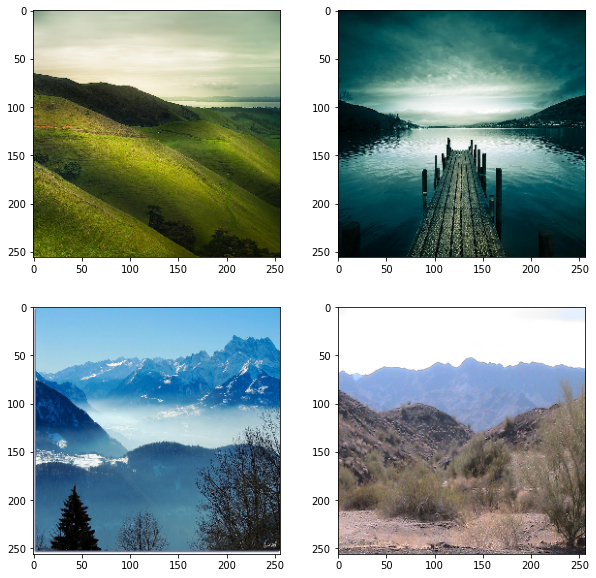

In [ ]:
# load a generator for visualisation first
visual_generator = ImageDataGenerator(fill_mode="reflect",
                                     horizontal_flip=True)
visual_flow = visual_generator.flow_from_directory("/content/drive/My Drive/Colab_Notebooks/", class_mode=None, target_size=(256,256), batch_size=1, shuffle=False)


images= []
for i in range(0,4):
  images.append(visual_flow.next()[0])

print(images[0].shape, images[0])

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow((images[0]).astype('uint8'))

plt.subplot(222)
plt.imshow((images[1]).astype('uint8'))

plt.subplot(223)
plt.imshow((images[2]).astype('uint8'))

plt.subplot(224)
plt.imshow((images[3]).astype('uint8'))

plt.show()

In [ ]:
def define_discriminator(in_shape=(256,256,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 8x8 image
	n_nodes = 256 * 8 * 8
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 256)))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# upsample to 128x128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# upsample to 256x256
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# to train the discriminator, we need a mix of real and fake images

def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# use the generator to generate n fake examples, with class labels 0
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

Why would we want to do this?

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

Let’s make this concrete.

Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
Outputs: Binary classification, likelihood the sample is real (or fake).
The define_gan() function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = '/content/drive/My Drive/Colab_Notebooks/plots_gan/generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = '/content/drive/My Drive/Colab_Notebooks/plots_gan/generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(4335 / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		print("Epoch", i, "/",n_epochs)
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			print("Batch", i, "/", bat_per_epo)
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			print("Discriminator trained on real")
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			print("Discriminator trained on fake")
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			print("Got GANs training samples")
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			print("GAN trained")
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim, n_samples=256)

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255,fill_mode="reflect",
                                     horizontal_flip=True)
train_flow = train_generator.flow_from_directory("/content/drive/My Drive/Colab_Notebooks/", class_mode=None, target_size=(512, 512), batch_size=500)

Found 4335 images belonging to 1 classes.


In [ ]:
dataset_train = []
print("Starting")
while True :
  temp_data = train_flow.next()
  print("Next batch", temp_data.size)
  for i in range(temp_data.shape[0]):
    dataset_train.append(temp_data[i])

Starting


NameError: ignored

In [ ]:
valid_flow = ImageDataGenerator(rescale=1/255,fill_mode="reflect",horizontal_flip=True).flow_from_directory("/content/drive/My Drive/Colab_Notebooks/", class_mode=None, target_size=(512, 512), batch_size=1)


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# train model
train(g_model, d_model, gan_model, train_flow, valid_flow, latent_dim)

Epoch 0 / 200
Batch 0 / 33


KeyboardInterrupt: ignored